In [1]:
from abc import abstractmethod, ABC
from sklearn.datasets import make_classification, make_moons
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, balanced_accuracy_score
from time import time
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427
n_trains = 1

In [2]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])
        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=random_state)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float]:
                continue

            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.small_x_train[:, i] = (self.small_x_train[:, i] - x_min) / (x_max - x_min)
                self.small_x_train[:, i] = self.small_x_train[:, i] * (max_v - min_v) + min_v

                self.big_x_train[:, i] = (self.big_x_train[:, i] - x_min) / (x_max - x_min)
                self.big_x_train[:, i] = self.big_x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
                self.small_x_train[:, i] = 1
                self.big_x_train[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float] or len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

            self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=random_state)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

In [3]:
class ActivationFunction(ABC):
    threshold = 0
    @abstractmethod
    def __call__(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    @abstractmethod
    def derivative(self, x: ndarray) -> ndarray:
        raise NotImplementedError

    def d(self, x: ndarray) -> ndarray:
        return self.derivative(x)


In [4]:
class MyNeuron:
    _accepted_activation_functions = ['Heaviside', 'sin', 'tanh', 'sign', 'Relu', 'LeakyRelu', 'sigmoid']

    class _Heaviside(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, 1, 0)

        def derivative(self, x: ndarray) -> ndarray:
            return np.ones_like(x)

    class _Sin(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.sin(x)

        def derivative(self, x: ndarray) -> ndarray:
            return np.cos(x)

    class _Tanh(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.tanh(x)

        def derivative(self, x: ndarray) -> ndarray:
            return 1 / (np.cosh(x) ** 2)

    class _Sign(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.sign(x)

        def derivative(self, x: ndarray) -> ndarray:
            return np.ones_like(x)

    class _Relu(ActivationFunction):
        def __call__(self, x: ndarray) -> ndarray:
            return np.where(x > 0, x, 0)

        def derivative(self, x: ndarray) -> ndarray:
            return np.where(x > 0, 1, 0)

    class _LeakyRelu(ActivationFunction):
        threshold = 0.01
        def __call__(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, x, 0.01 * x)

        def derivative(self, x: ndarray) -> ndarray:
            return np.where(x >= 0, 1, 0.01)

    class _Sigmoid(ActivationFunction):
        threshold = 0.5
        def __call__(self, x: ndarray) -> ndarray:
            return 1 / (1 + np.exp(-x))

        def derivative(self, x: ndarray) -> ndarray:
            return self(x) * (1 - self(x))

    @staticmethod
    def expand_features(X: ndarray) -> ndarray:
        return np.c_[np.ones(X.shape[0])*-1, X]

    def __init__(self, lr: float = 0.01, min_lr: float = 0.005, max_lr: float = 0.01, activation: str= 'Relu', batch_size: int=8, epochs: int = 1000, verbose: bool = True, dynamic_lr: bool = False):
        if activation not in self._accepted_activation_functions:
            raise ValueError(f'Activation function {activation} is not supported')

        self.learning_rate = lr
        self.min_learning_rate = min_lr
        self.max_learning_rate = max_lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.dynamic_lr = dynamic_lr
        self.coef_ = None
        self.activation = {'Heaviside': self._Heaviside(),
                           'sin': self._Sin(),
                           'tanh': self._Tanh(),
                           'sign': self._Sign(),
                           'Relu': self._Relu(),
                           'LeakyRelu': self._LeakyRelu(),
                           'sigmoid': self._Sigmoid()}[activation]

    def fit(self, X, Y):
        X = self.expand_features(X)
        if self.coef_ is None:
            self.coef_ = np.random.normal(loc=1, scale=.15, size=(1, X.shape[1]))

        Y = Y.reshape(-1, 1)
        n = X.shape[0]
        batch_divisible = n - n % self.batch_size

        for e in tqdm(range(self.epochs), disable=not self.verbose):
            indexes = np.arange(0, n, 1)
            np.random.shuffle(indexes)
            batched_X = X[indexes]
            batched_Y = Y[indexes]

            batched_X = batched_X[:batch_divisible]
            batched_Y = batched_Y[:batch_divisible]

            for i in range(0, batch_divisible, self.batch_size):
                X_batch = batched_X[i:i+self.batch_size]
                Y_batch = batched_Y[i:i+self.batch_size]
                preds = self.activation(np.dot(X_batch, self.coef_.T))

                dW = (Y_batch - preds) * self.activation.d(X_batch.dot(self.coef_.T)) * X_batch
                self.coef_ += self.learning_rate * dW.mean(axis=0)

            if self.dynamic_lr:
                self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate) * (1 + np.cos(e / self.epochs * np.pi))

        return self

    def decision_function(self, X):
        X = self.expand_features(X)
        return self.activation(X.dot(self.coef_.T))

    def predict(self, X):
        return np.where(self.decision_function(X) > self.activation.threshold, 1, 0)


In [5]:
def display_neuron_with_activation_and_batch_size(data: PUMData, activation = 'Relu', batch_size=8, dynamic_lr=False, epochs=100):

    print(f'Training {n_trains} times with activation {activation} and dynamic lr={dynamic_lr}')

    model = MyNeuron(activation=activation, batch_size=batch_size, epochs=epochs, dynamic_lr=dynamic_lr)
    model.fit(data.x_train, data.y_train)

    f, ax = plt.subplots(1, 3, tight_layout=True, figsize=(20, 10))
    f.suptitle(f'Neuron {activation}, batch size {batch_size}, epochs {epochs}')

    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_data).reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4, levels=1)
    ax[0].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)

    predictions = model.predict(data.x_test)
    cm = confusion_matrix(data.y_test, predictions, labels=[0, 1])
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    sns.heatmap(cm, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title(f'Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, predictions, adjusted=True)}')

    decision_function = model.decision_function(data.x_test)
    fpr, tpr, thresholds = roc_curve(data.y_test, decision_function)
    ax[2].plot(fpr, tpr, label=f'Model AUC={roc_auc_score(data.y_test, decision_function):.3f}')
    ax[2].plot([0, 1], [0, 1], 'k--')
    ax[2].set_xlabel('FPR')
    ax[2].set_ylabel('TPR')
    ax[2].set_title('ROC')
    ax[2].legend()
    plt.show()
    return balanced_accuracy_score(data.y_test, predictions, adjusted=True)


In [6]:
single_mod_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.05, random_state=random_state))

Training 1 times with activation sigmoid and dynamic lr=False


100%|██████████| 1000/1000 [00:51<00:00, 19.40it/s]


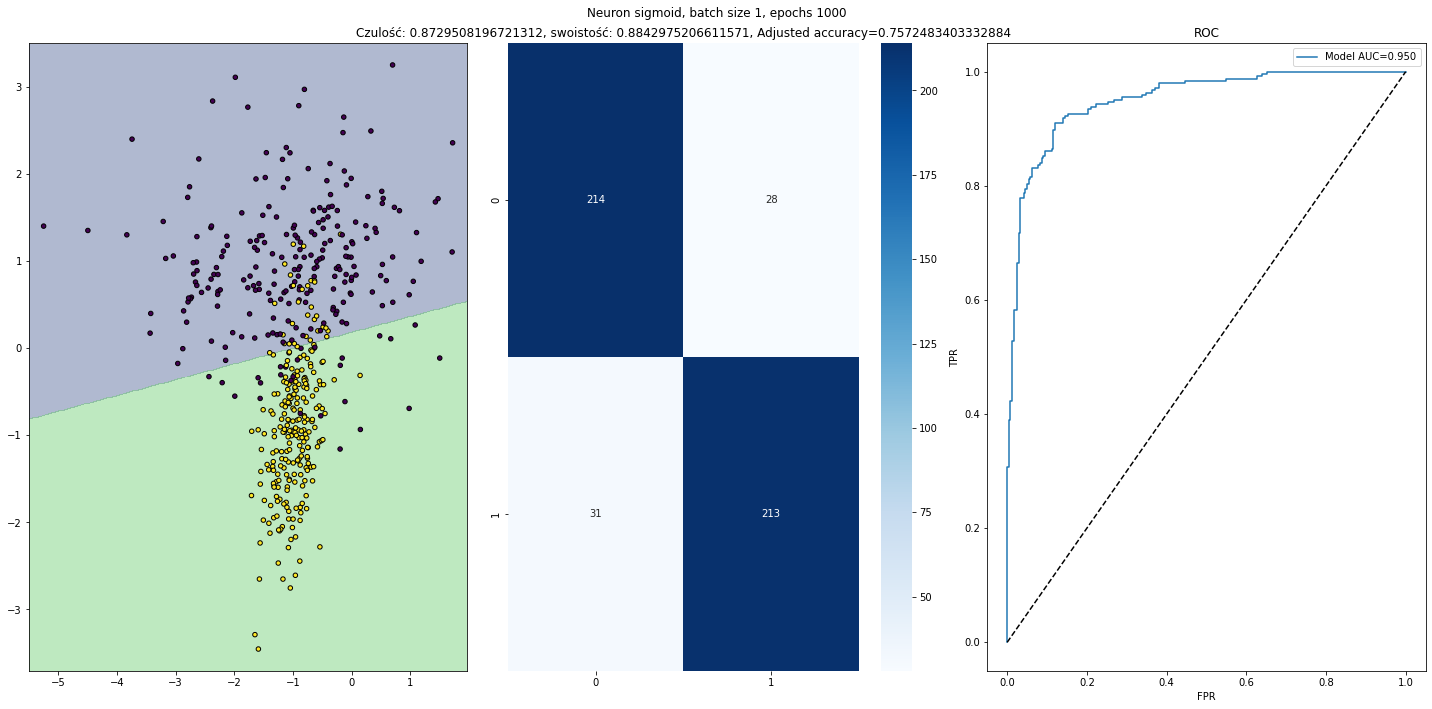

Training 1 times with activation sigmoid and dynamic lr=False


100%|██████████| 1000/1000 [00:50<00:00, 19.76it/s]


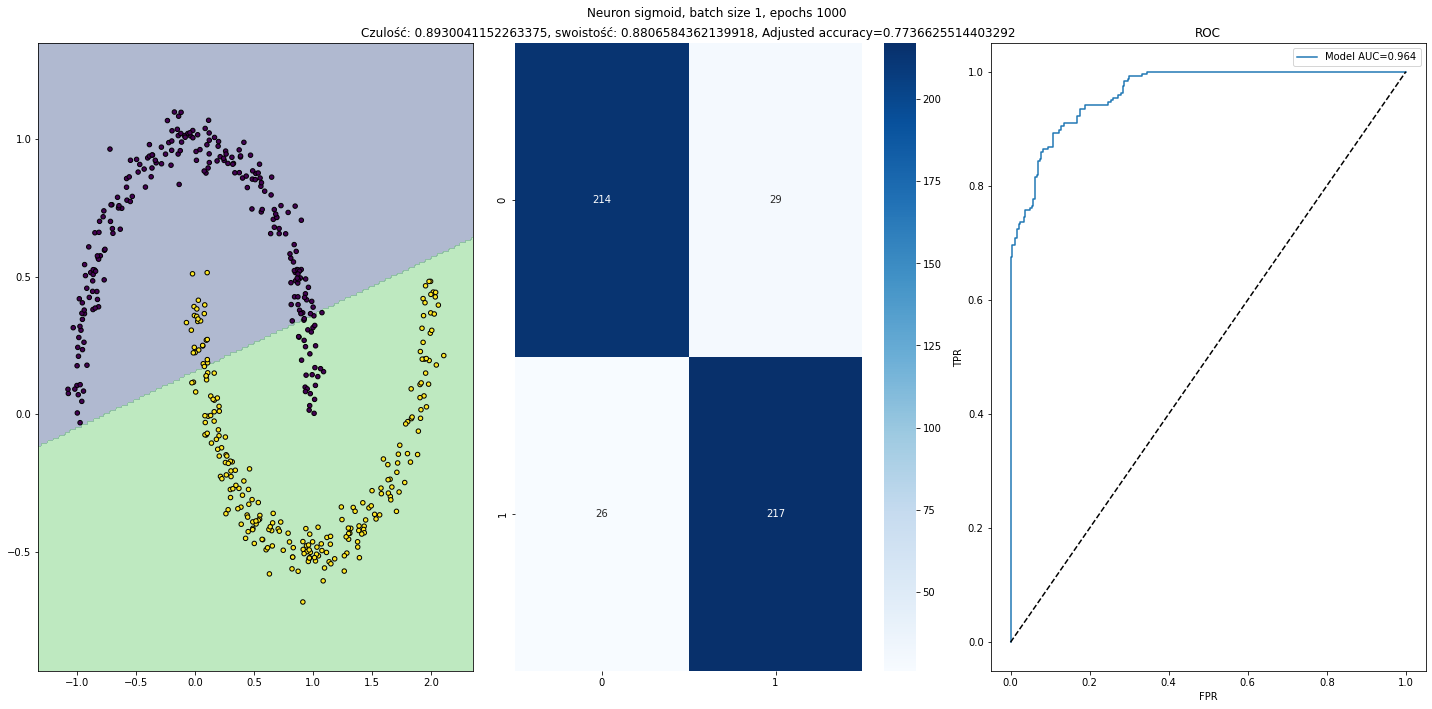

In [7]:
linear_aba = []
moons_aba = []

linear_aba.append(display_neuron_with_activation_and_batch_size(single_mod_data, activation='sigmoid', batch_size=1, dynamic_lr=False, epochs=1000))
moons_aba.append(display_neuron_with_activation_and_batch_size(data_moons, activation='sigmoid', batch_size=1, dynamic_lr=False, epochs=1000))

Training 1 times with activation Heaviside and dynamic lr=True


100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s]


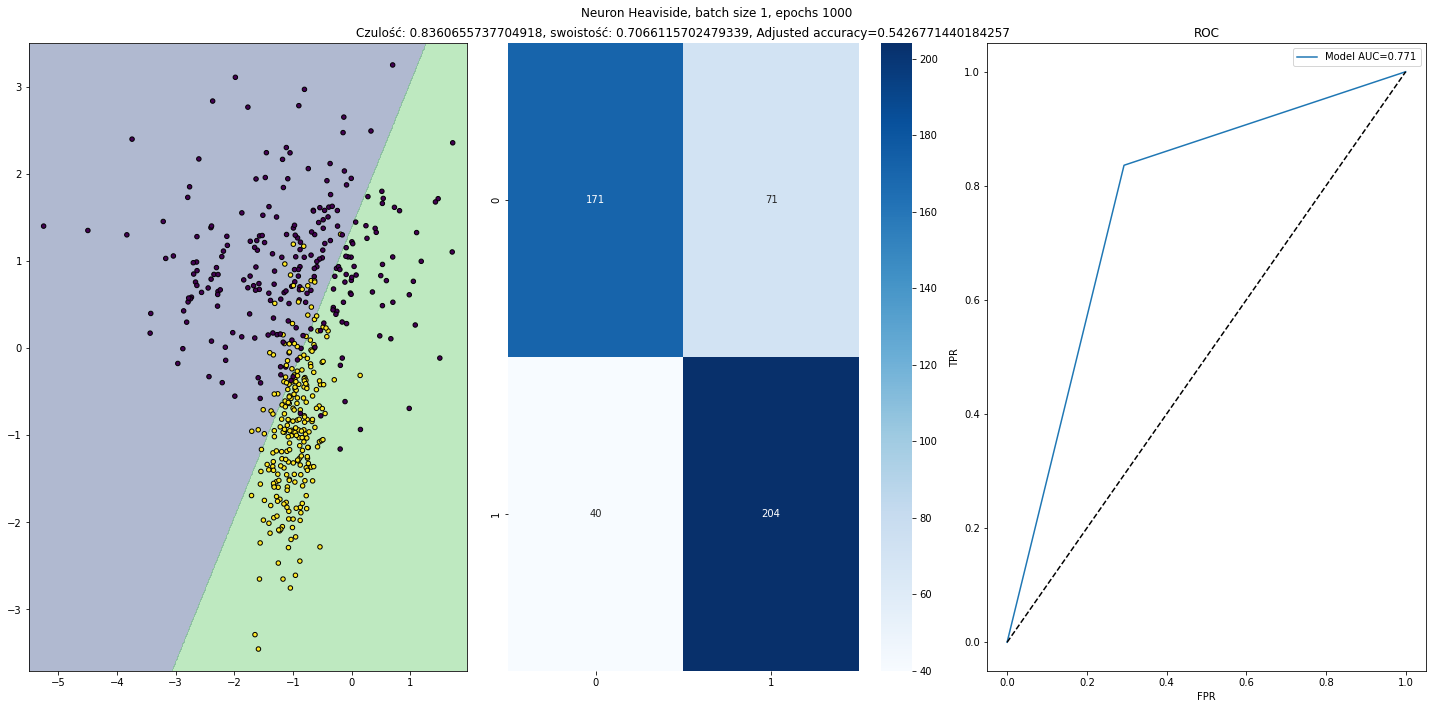

Training 1 times with activation Heaviside and dynamic lr=True


100%|██████████| 1000/1000 [00:06<00:00, 157.98it/s]


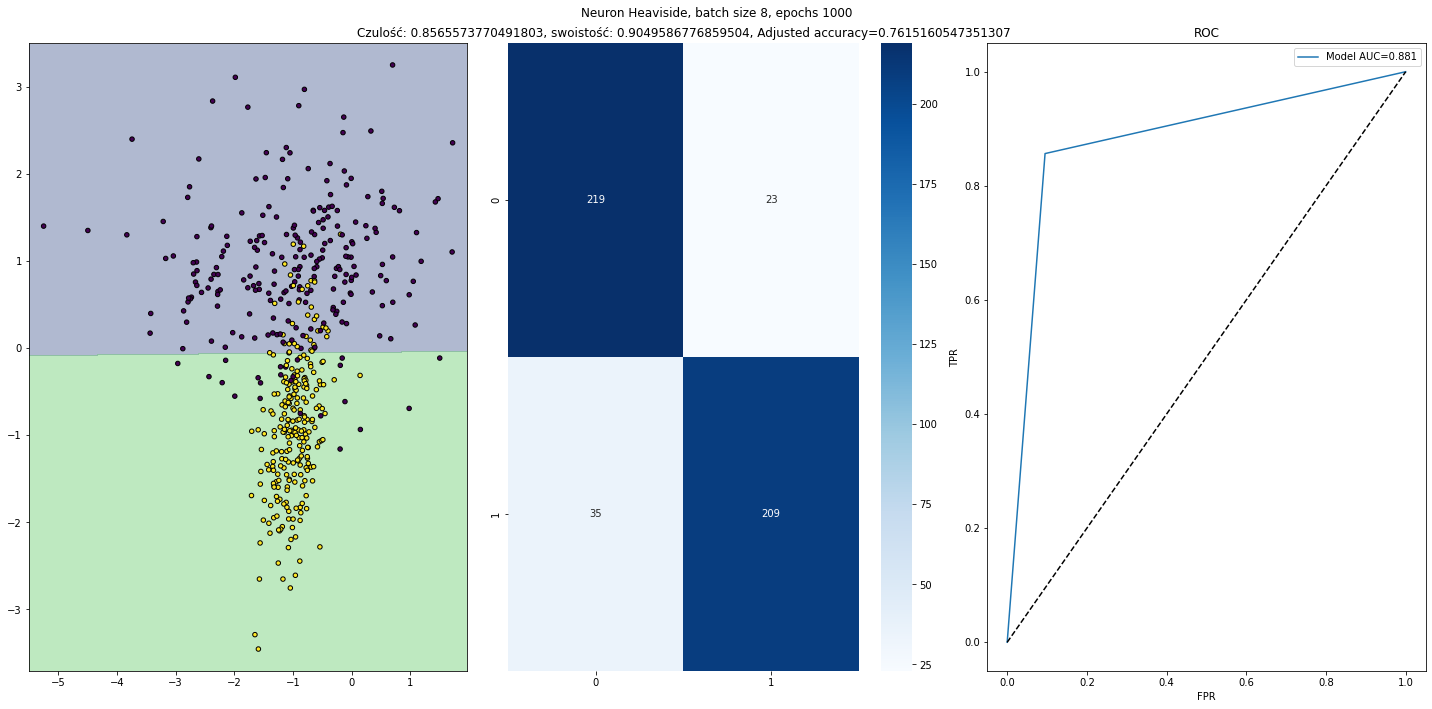

Training 1 times with activation Heaviside and dynamic lr=True


100%|██████████| 1000/1000 [00:01<00:00, 605.99it/s]


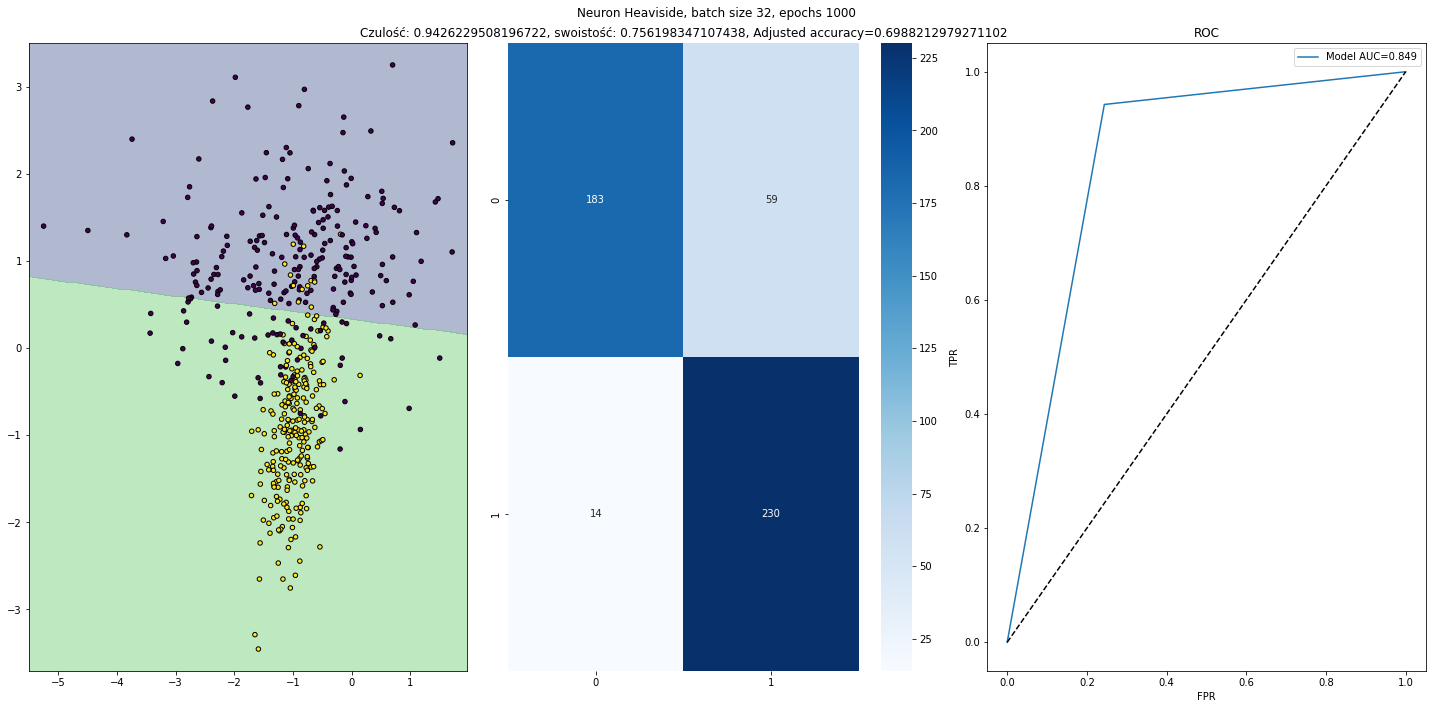

Training 1 times with activation sin and dynamic lr=True


100%|██████████| 1000/1000 [00:35<00:00, 28.31it/s]


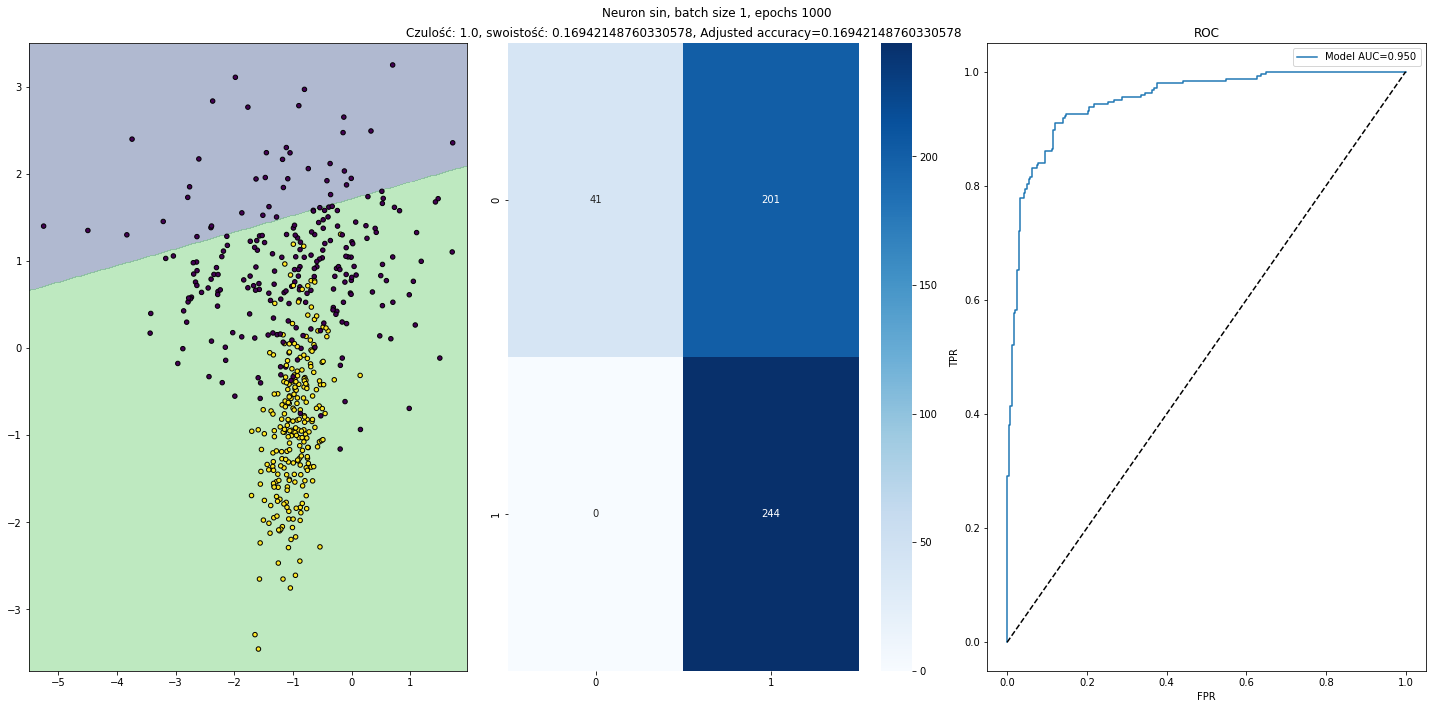

Training 1 times with activation sin and dynamic lr=True


100%|██████████| 1000/1000 [00:04<00:00, 212.69it/s]


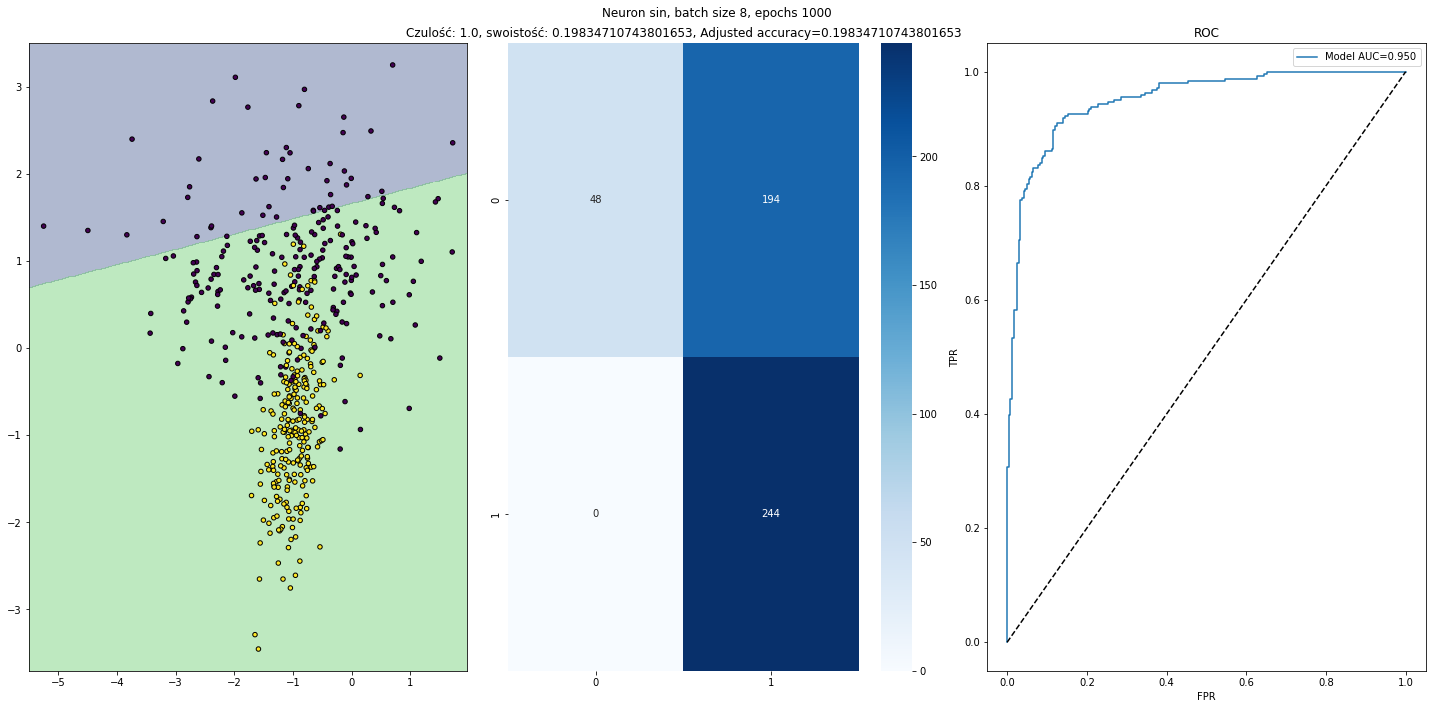

Training 1 times with activation sin and dynamic lr=True


100%|██████████| 1000/1000 [00:01<00:00, 778.13it/s]


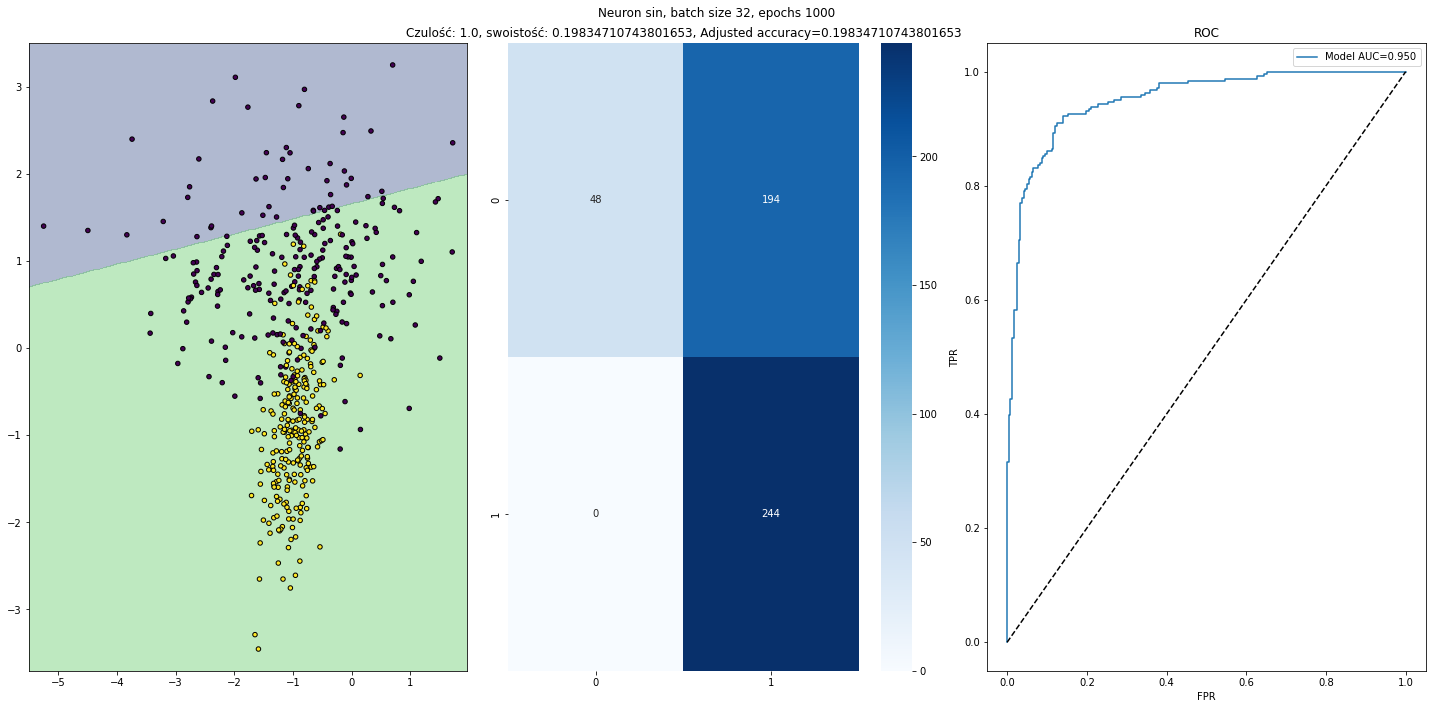

Training 1 times with activation tanh and dynamic lr=True


100%|██████████| 1000/1000 [00:41<00:00, 24.38it/s]


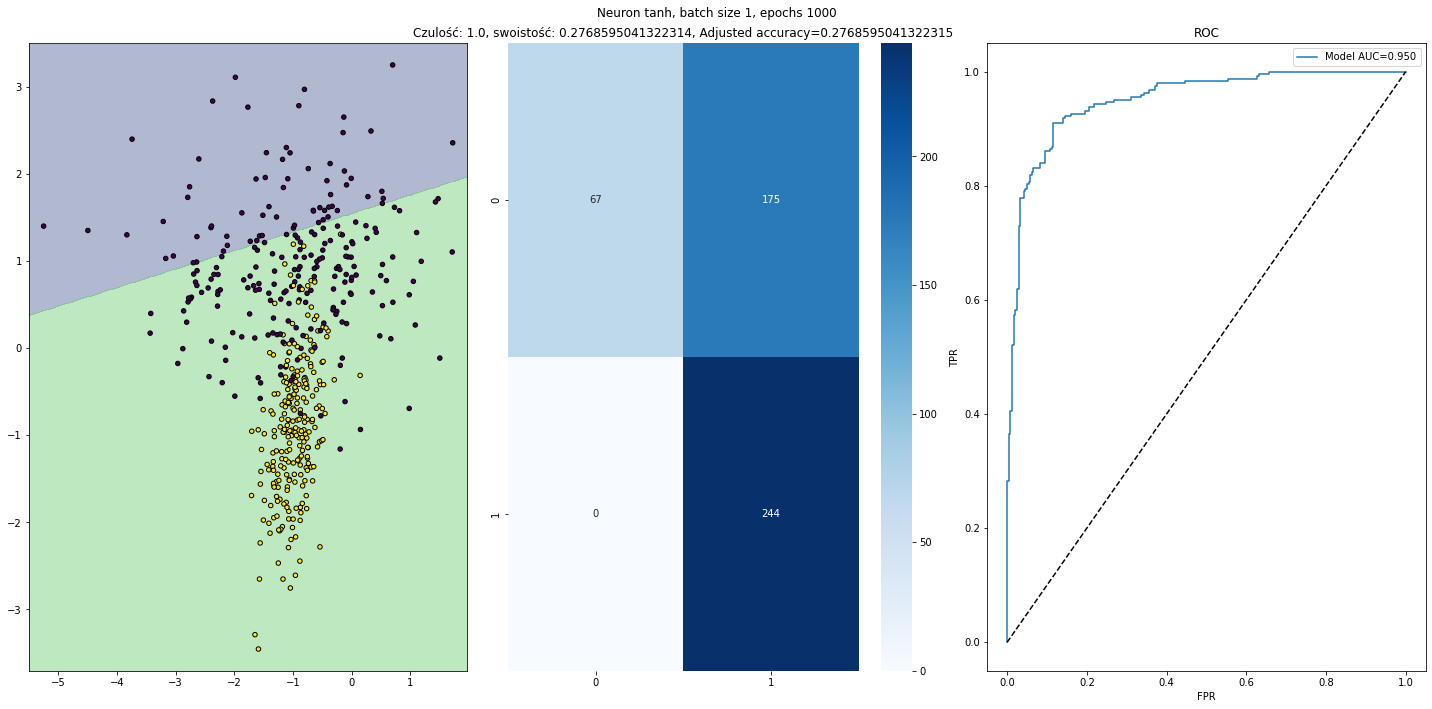

Training 1 times with activation tanh and dynamic lr=True


100%|██████████| 1000/1000 [00:05<00:00, 183.25it/s]


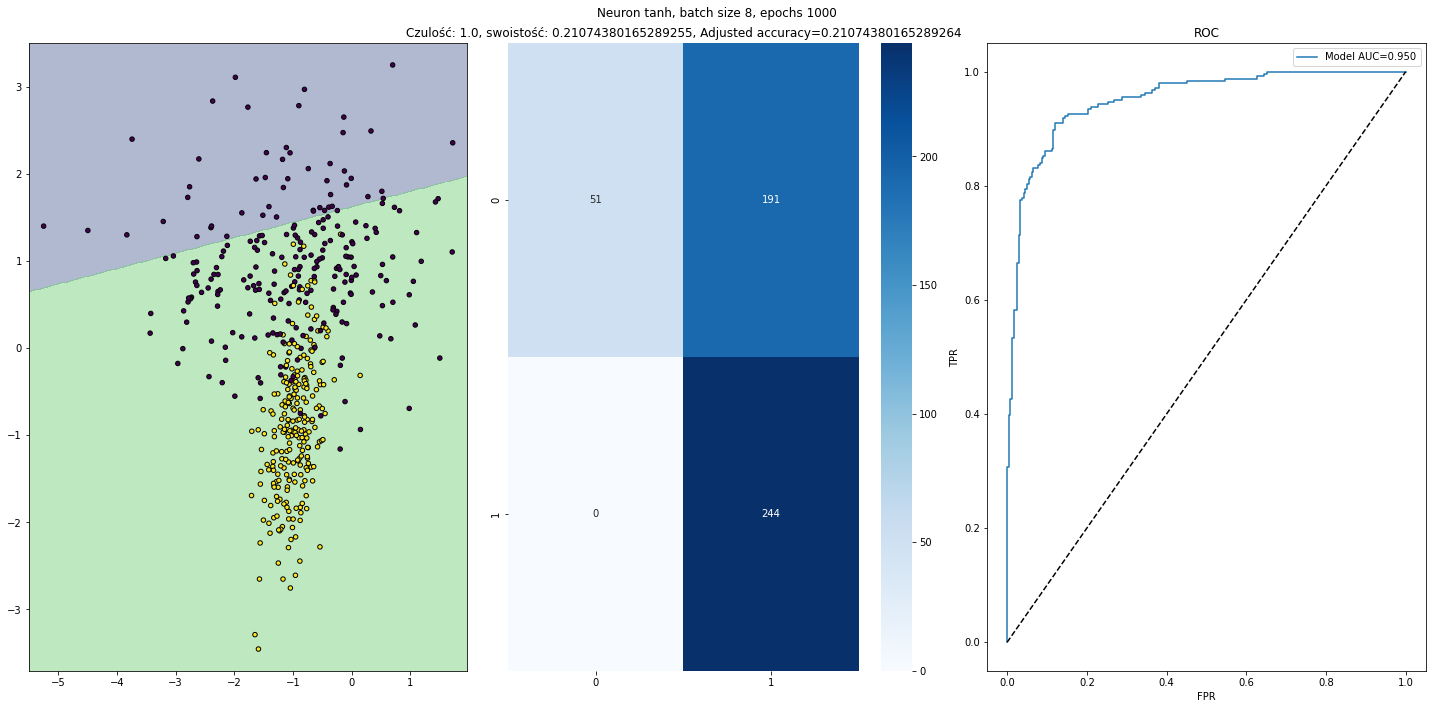

Training 1 times with activation tanh and dynamic lr=True


100%|██████████| 1000/1000 [00:01<00:00, 642.28it/s]


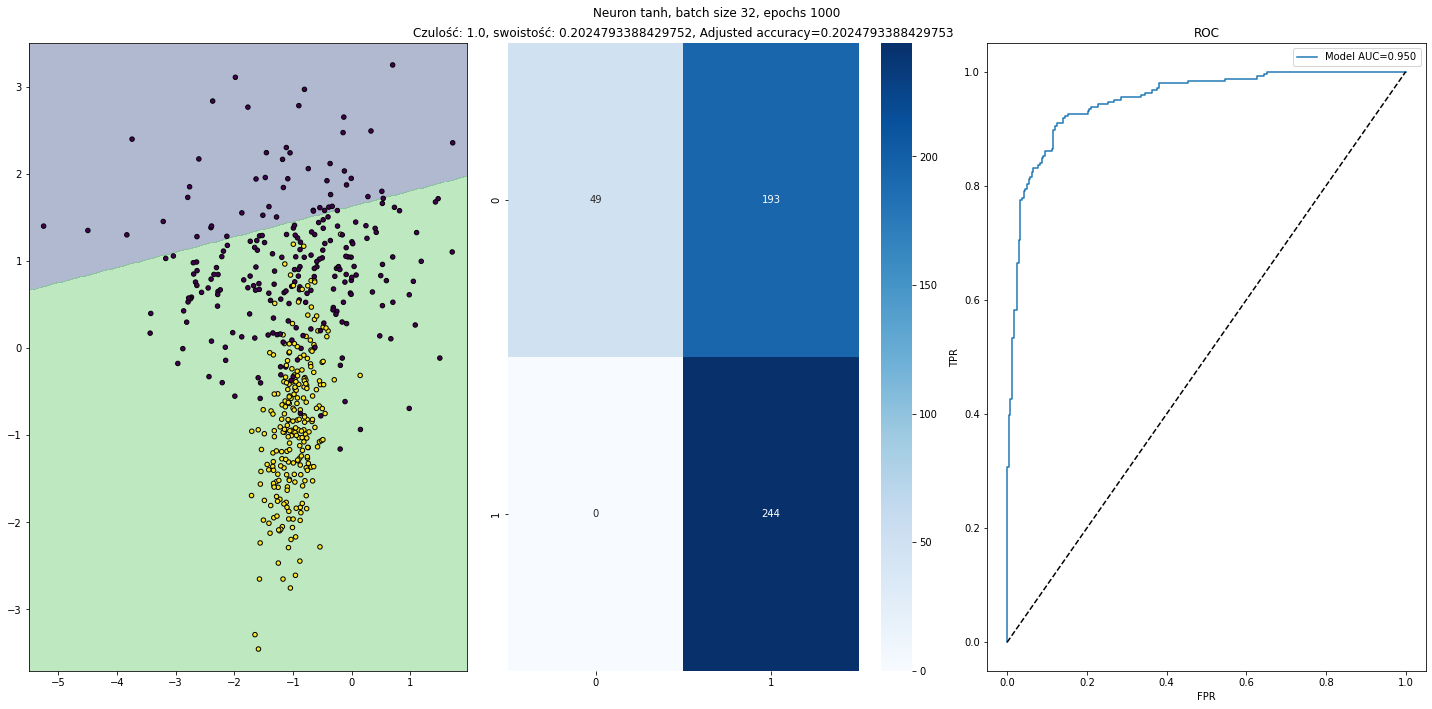

Training 1 times with activation sign and dynamic lr=True


100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]


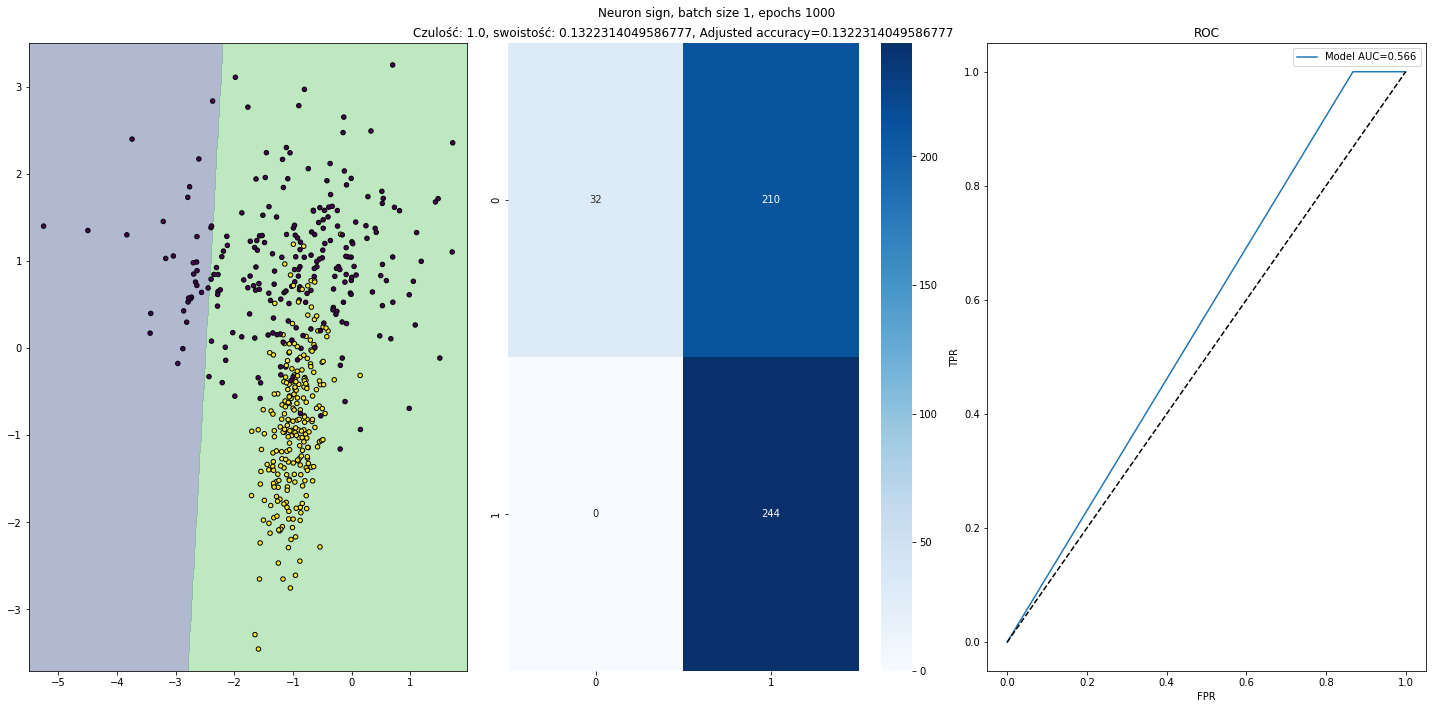

Training 1 times with activation sign and dynamic lr=True


100%|██████████| 1000/1000 [00:07<00:00, 132.39it/s]


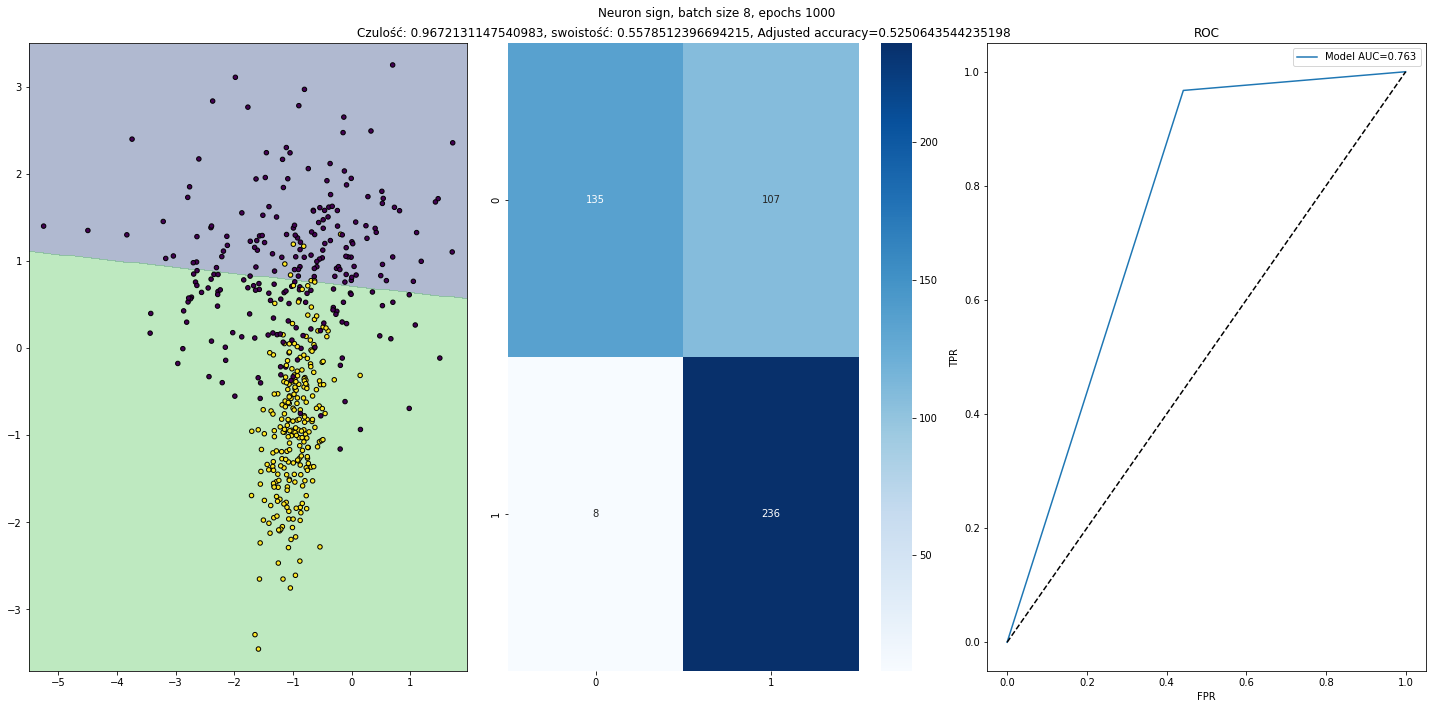

Training 1 times with activation sign and dynamic lr=True


100%|██████████| 1000/1000 [00:01<00:00, 508.10it/s]


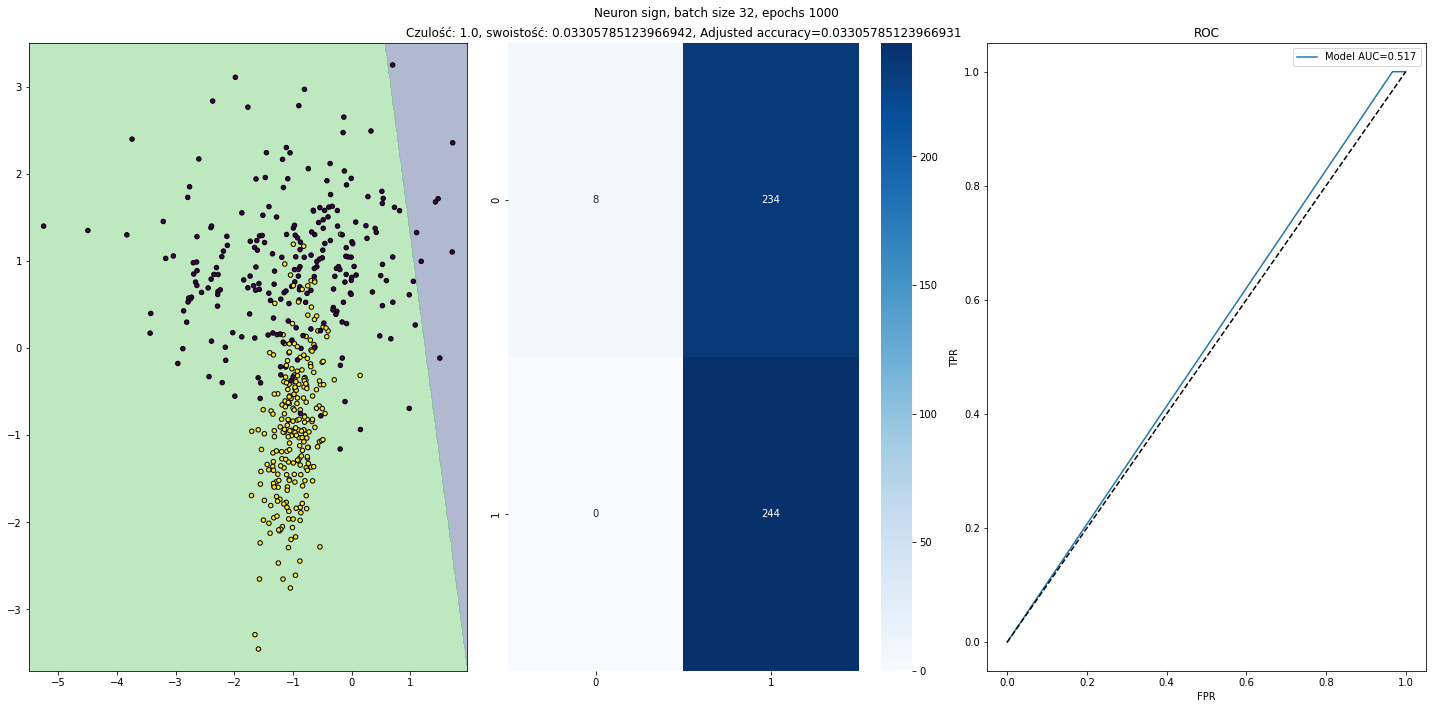

Training 1 times with activation Relu and dynamic lr=True


100%|██████████| 1000/1000 [00:56<00:00, 17.67it/s]


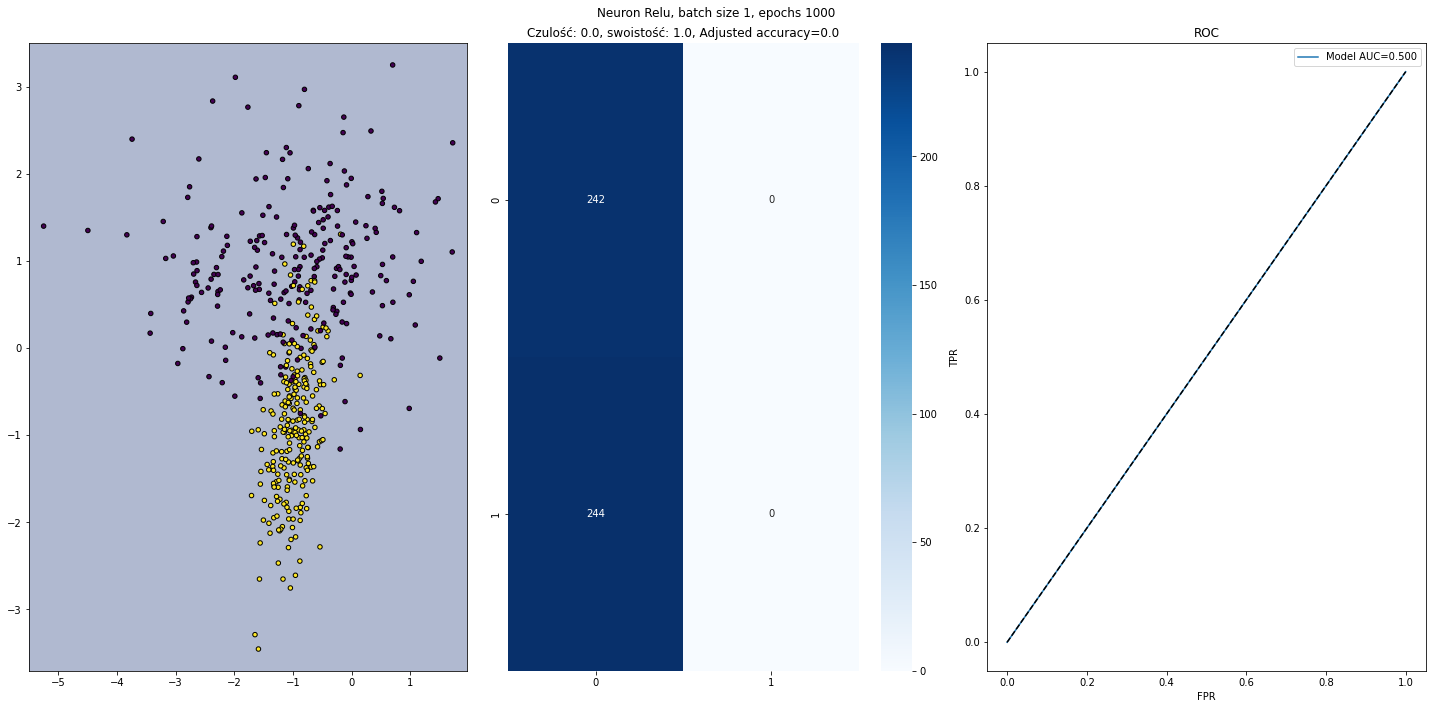

Training 1 times with activation Relu and dynamic lr=True


100%|██████████| 1000/1000 [00:06<00:00, 148.02it/s]


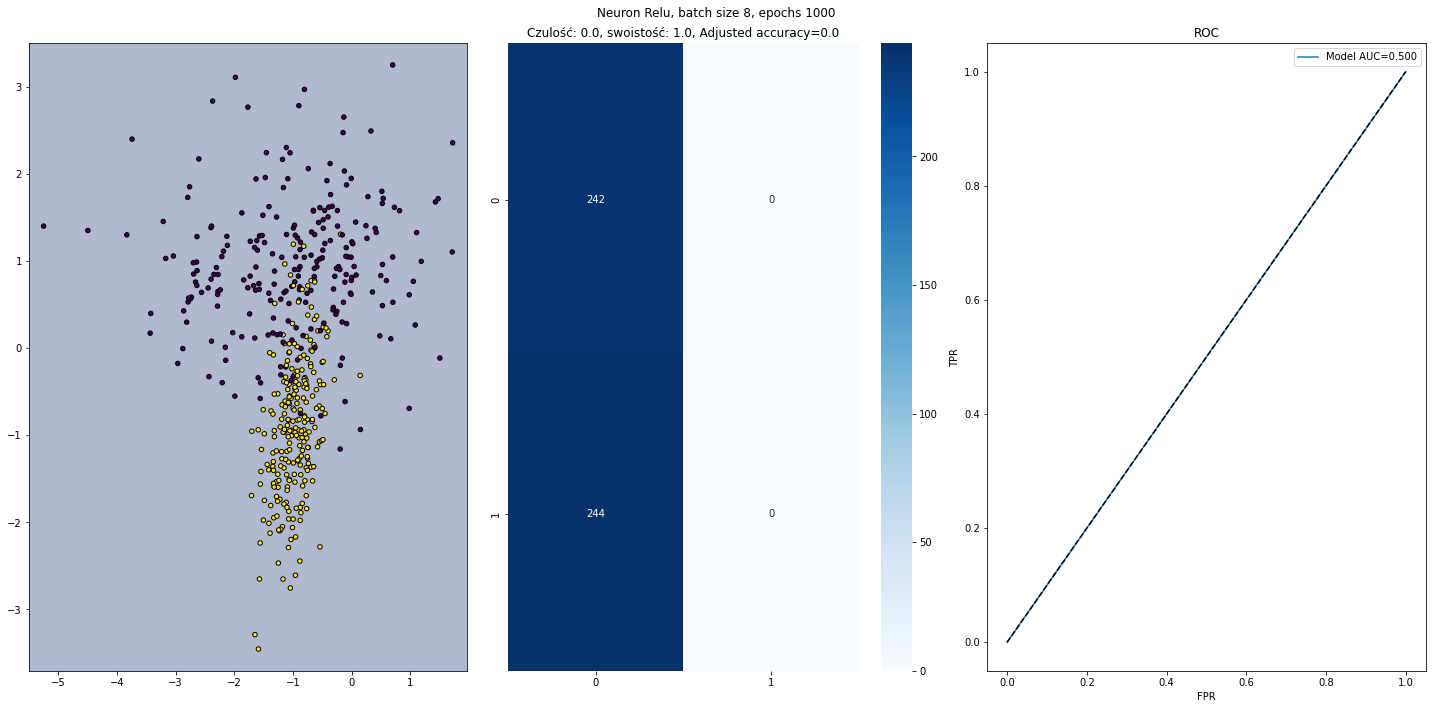

Training 1 times with activation Relu and dynamic lr=True


100%|██████████| 1000/1000 [00:01<00:00, 600.57it/s]


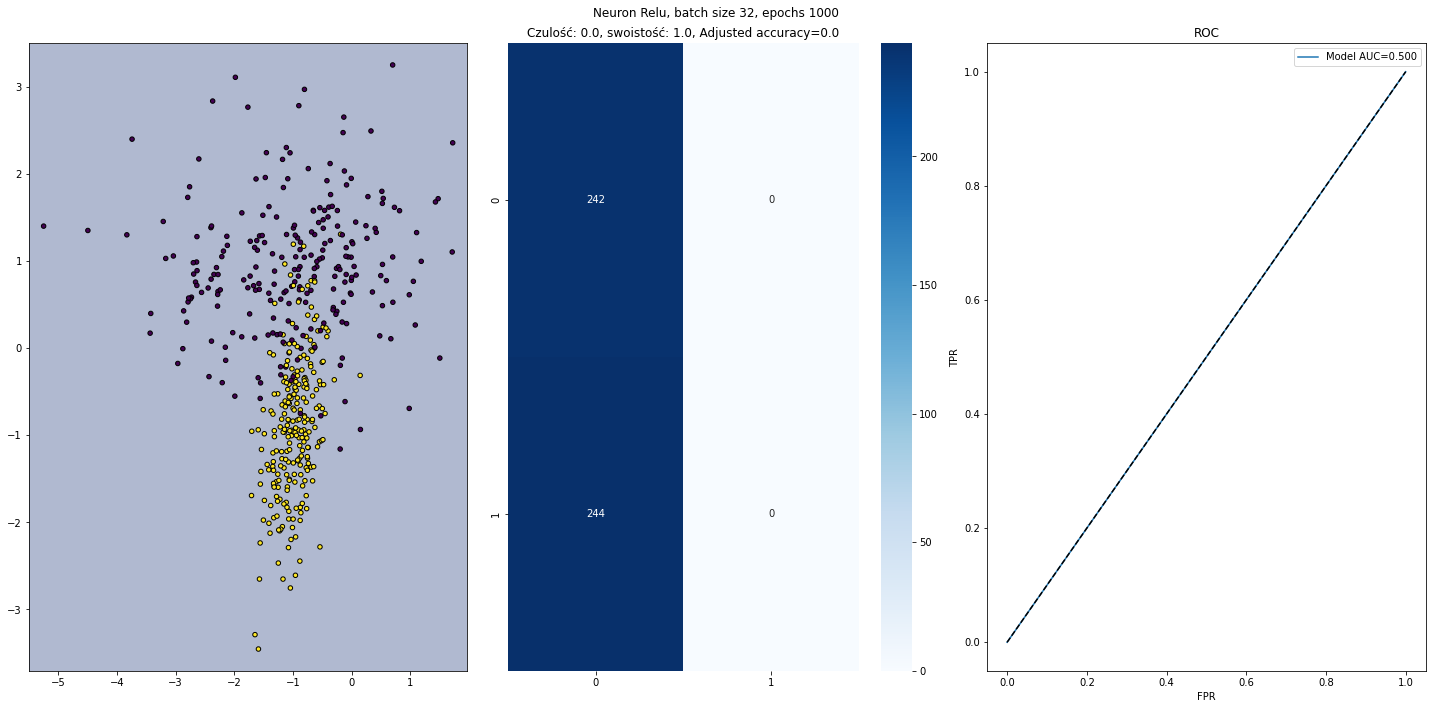

Training 1 times with activation LeakyRelu and dynamic lr=True


100%|██████████| 1000/1000 [00:52<00:00, 18.88it/s]


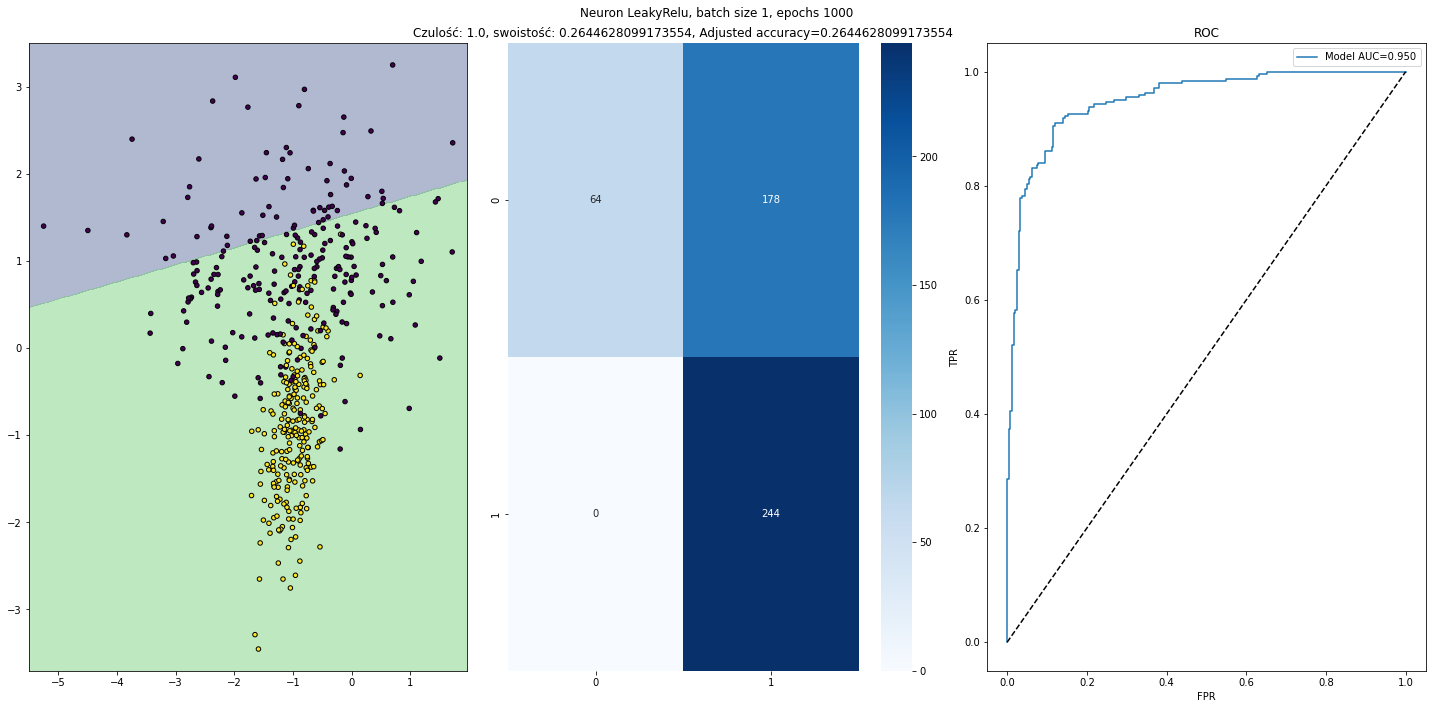

Training 1 times with activation LeakyRelu and dynamic lr=True


100%|██████████| 1000/1000 [00:05<00:00, 172.07it/s]


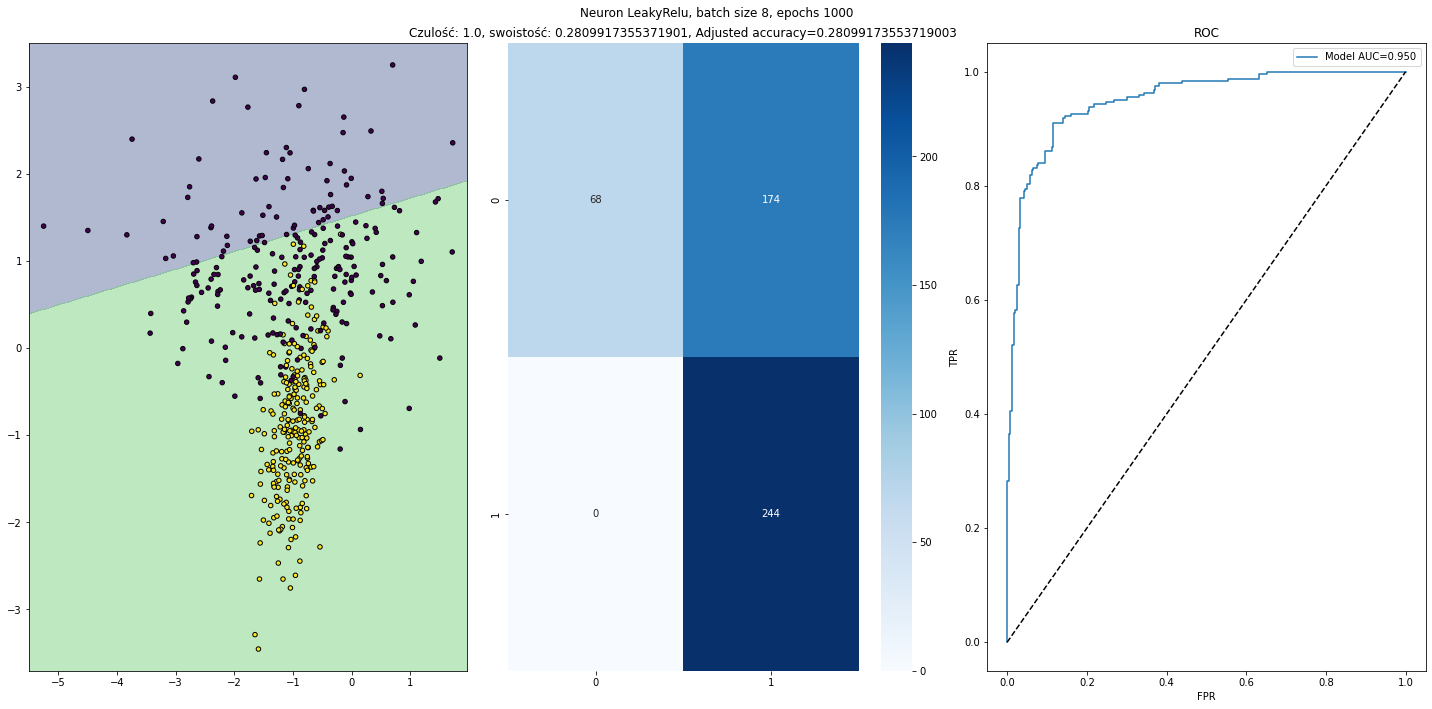

Training 1 times with activation LeakyRelu and dynamic lr=True


100%|██████████| 1000/1000 [00:01<00:00, 644.33it/s]


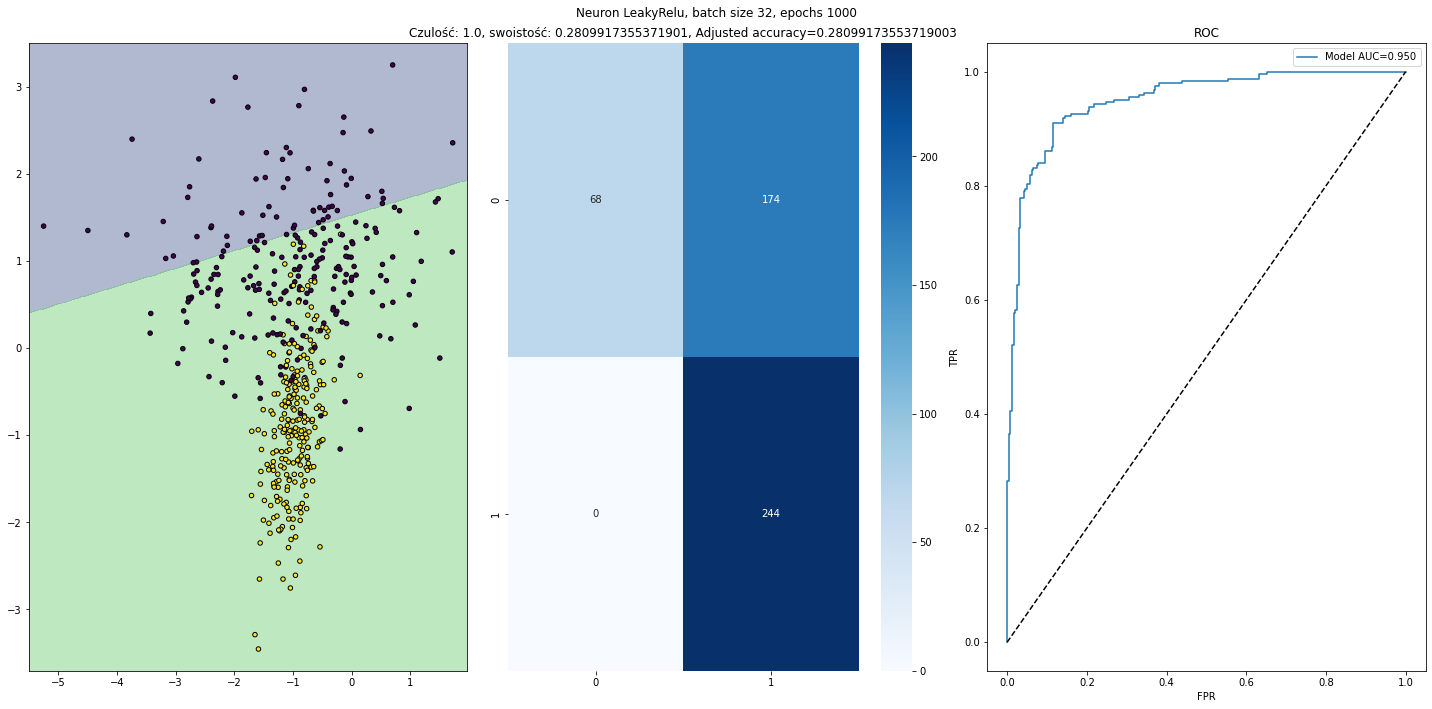

In [8]:
activations = ['Heaviside', 'sin', 'tanh', 'sign', 'Relu', 'LeakyRelu']
batches = [1,8,32]

linear_scores = {}
moons_scores = {}

for activation in activations:
    for batch in batches:
        key = f'{activation}_{batch}'
        linear_scores[key] = display_neuron_with_activation_and_batch_size(single_mod_data, activation=activation, batch_size=batch, dynamic_lr=True, epochs=1000)
        # moons_scores[key] = display_neuron_with_activation_and_batch_size(data_moons, activation=activation, batch_size=batch, dynamic_lr=True, epochs=1000)

In [9]:
print(sorted(linear_scores, key=linear_scores.get, reverse=True)[:5])

['Heaviside_8', 'Heaviside_32', 'Heaviside_1', 'sign_8', 'LeakyRelu_8']
